# **Part 2: Class-Conditional GANs for Image Generation** (20 points)

### **Learning Objectives**
- Implement and train a class-conditional GAN on `MNIST`
- Quantitatively evaluate model performance using `Fréchet Inception Distance (FID)`

### **Implementation Tasks**
1. **Model Training**:
   - Train a class-conditional GANs that generates MNIST digits
        - Vanilla GAN Loss
        - Non-Saturating Loss with $R_1$ regularization
        - Non-Saturating Loss with $R_1$ regularization and unconditional discriminator

2. **Performance Evaluation**:
   - Compute FID scores between generated and real MNIST samples
   - Compare results across different training configurations

### **Resources**

- **GAN's Tutorial:** [From GAN to WGAN](https://lilianweng.github.io/posts/2017-08-20-gan/)

- **Implementation Examples:** [PyTorch-GAN Repo](https://github.com/eriklindernoren/PyTorch-GAN/tree/master)

In [31]:
#!pip install torchmetrics[image] -q

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [33]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 1. Dataset Preparation (1 point)

Use the MNIST dataset from `torchvision.datasets`. Note that the sampled batches $B_{ds}$ from the dataset must include the class labels of the images.

In [34]:
pix_range = (-1., 1.)
_m, _std = pix_range[0]/float(pix_range[0] - pix_range[1]), 1./float(pix_range[1] - pix_range[0])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([_m],[_std]) 
])

mnist_dataset = MNIST(
    root='./',      # where to store/download the data
    train=True,         # use the training split
    download=False,      # download if not already there
    transform=transform # apply the transforms
)

batch_size = 10
dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True        # shuffle for each epoch
)

In [35]:
mnist_dataset[0][0].shape

torch.Size([1, 28, 28])

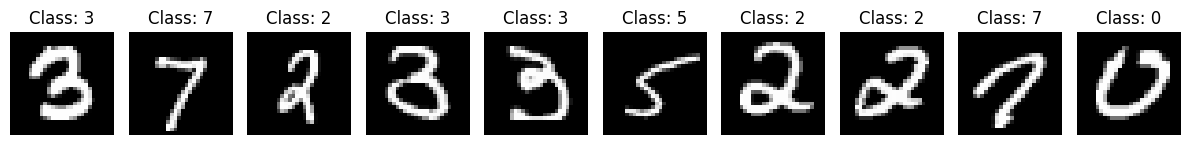

In [36]:
def show_batch(data_loader: DataLoader):
    images, labels = next(iter(data_loader))     # grab one batch
    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for ax, img, lbl in zip(axes, images, labels):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Class: {lbl.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


show_batch(dataloader)

## 2. Generator and Discriminator architecture (3 points)  

In this task you should implement architecture for generator and discriminator models.

The generator model ${\color{blue}G_\theta}(z, c)$ should take as input:  
- A latent vector $z \sim {\color{purple}p_Z}(\cdot)$  
- A class label $\color{orange}c$ (digit)  

The class-conditional discriminator ${\color{red}D_\omega}(x, c)$ must accept:  
- Real/generated `MNIST` images $x$ 
- The corresponding class label $\color{orange}c$  

**Note:** When working with images, it is common to use **Convolutional Neural Networks (CNNs)**. Such architectures were covered in **Assignment 3.2** during the **1st GAN seminar**.  

There are various approaches to applying conditions—in this task, you must implement the simplest method:  
- Use `nn.Embedding` to obtain embeddings for class vectors (of the required dimension)  
- Feed the generator (or discriminator) the concatenation of either:  
  - Noise + corresponding class embeddings (for the generator)  
  - Images + corresponding class embeddings (for the discriminator)  

In [37]:
def plot_images(batch_x: torch.Tensor, batch_y: torch.Tensor, title: str | None = None):
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    if title is not None:
        fig.suptitle(title)
    for i in range(10):
        axes[i].set_title(f"Label: {round(batch_y[i].item())}")
        axes[i].imshow(batch_x[i].squeeze(), cmap="gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()


def plot_losses(gen_losses: list[float], disc_losses: list[float]) -> None:
    _, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(gen_losses)
    axes[0].set_title("Generator Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].grid("on")

    axes[1].plot(disc_losses)
    axes[1].set_title("Discriminator Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].grid("on")
    plt.show()

**Select a model architecture.** You may:  
- Use an entirely new class, **or**  
- Adapt the proposed structure.  

For implementation guidance, you may refer to:  
- Seminar materials  
- [PyTorch’s DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

In [38]:
# IMAGE_SIZE = 28       # MNIST images are 28x28
# NUM_IMAGE_CHANNELS = 1 # Number of channels in the training images (MNIST is grayscale)
# NOISE_DIM = 100       # Size of latent vector (input_size for Generator) - matching signature default
# NGF = 64              # Size of feature maps in generator
# NDF = 64              # Size of feature maps in discriminator
# NUM_CLASSES = 10      # MNIST has 10 classes (0-9) - matching signature default
# EMBEDDING_DIM = 50    # Dimension of the class embedding (internal hyperparameter)

In [77]:
import torch
import torch.nn as nn

class ConditionalConvGenerator(nn.Module):
    def __init__(
        self,
        input_size: int = 128,
        num_classes: int = 10,
        device: torch.device = DEVICE,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.n_channels = 64  # base channel count
        self.num_classes = num_classes
        self.device = device

        # embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, input_size)

        # project (noise + label) to feature map
        self.linear_block = nn.Sequential(
            nn.Linear(input_size * 2, self.n_channels * 7 * 7),
            nn.BatchNorm1d(self.n_channels * 7 * 7),
            nn.ReLU(True),
        )
        # upsample to 28x28
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(
                self.n_channels, self.n_channels // 2, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(self.n_channels // 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                self.n_channels // 2,
                self.n_channels // 4,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(self.n_channels // 4),
            nn.ReLU(True),
            nn.Conv2d(self.n_channels // 4, 1, kernel_size=3, padding=1),
            nn.Tanh(),
        )

        # standard normal noise distribution
        self.noise = torch.distributions.Normal(
            torch.tensor(0.0, device=self.device),
            torch.tensor(1.0, device=self.device),
        )

    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # z: (batch, input_size)
        # labels: (batch,)
        batch_size = z.size(0)
        # embed labels and concatenate
        label_vec = self.label_embedding(labels.to(self.device))  # (batch, input_size)
        x = torch.cat([z, label_vec], dim=1)  # (batch, 2*input_size)

        # project and reshape
        x = self.linear_block(x)
        x = x.view(batch_size, self.n_channels, 7, 7)
        # upsample to image
        x = self.conv_block(x)
        return x  # (batch, 1, 28, 28)

    def sample(self, num_samples: int, labels: torch.Tensor) -> torch.Tensor:
        # sample random noise
        z = self.noise.sample([num_samples, self.input_size]).to(self.device)
        return self.forward(z, labels)


class ConditionalConvDiscriminator(nn.Module):
    def __init__(
        self,
        num_classes: int = 10,
        device: torch.device = DEVICE,
    ) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.n_channels = 64
        self.device = device

        # embedding for class labels to full image size
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # convolutional backbone: input channels = 1 (image) + 1 (label map)
        self.net = nn.Sequential(
            nn.Conv2d(2, self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_channels, 2 * self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2 * self.n_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2 * self.n_channels, 4 * self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(4 * self.n_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # final linear layer
        # input feature map size = 4*n_channels x 3 x 3
        self.linear = nn.Linear(4 * self.n_channels * 4 * 4, 1)

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # x: (batch, 1, 28, 28)
        # labels: (batch,)
        batch_size = x.size(0)
        # get label maps
        label_map = self.label_embedding(labels.to(self.device))
        label_map = label_map.view(batch_size, 1, 28, 28)
        # concatenate image and label map
        x = torch.cat([x.to(self.device), label_map], dim=1)  # (batch, 2, 28, 28)
        # conv backbone
        x = self.net(x)
        x = x.view(batch_size, -1)
        logits = self.linear(x)
        return logits


class VanillaConditionalConvDiscriminator(ConditionalConvDiscriminator):
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        logits = super().forward(x, labels)
        probs = torch.sigmoid(logits)
        return probs

## 3. Training Algorithm for Class-Conditional GAN Model (7 points)  
Implement the training of a class-conditional GAN model. There are different ways to incorporate the condition—in this task, you need to implement the simplest approach: using `nn.Embedding` to obtain embeddings for the class vector (of the required dimension) and feeding the concatenation of the noise (or image) and the corresponding class embeddings as input to the generator (or discriminator).

For the GAN loss, use:  
1. **Vanilla GAN loss (3 point)**  
2. **Non-saturating GAN loss (with $R_1$ regularization)** as discussed in the seminar **(3 points)**  

During training, when generating a batch $B_{GAN}$ using the GAN, use **exactly the same class labels** as those provided in the batch from the true distribution $B_{ds}$.

### 3.1 Training class conditioned GANs with Vanilla GAN loss (3 points)

You need to adapt code from the seminar to conditional setup.

In [40]:

# def vanilla_gen_cond_step(
#     X: torch.Tensor, labels: torch.Tensor, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer
# ) -> torch.Tensor:
#     G_optim.zero_grad()
#     batch_size = X.size(0)
#     fake_images = G.sample(batch_size, labels)
#     fake_output = D(fake_images, labels)
#     g_loss = F.binary_cross_entropy(fake_output, torch.ones_like(fake_output))
#     g_loss.backward()
#     G_optim.step()
#     return g_loss.item()


# def vanilla_discr_cond_step(
#     X: torch.Tensor,
#     labels: torch.Tensor,
#     G: nn.Module,
#     D: nn.Module,
#     D_optim: torch.optim.Optimizer,
# ) -> torch.Tensor:
#     D_optim.zero_grad()
#     batch_size = X.size(0)
#     real_output = D(X, labels)
#     real_loss = F.binary_cross_entropy(real_output, torch.ones_like(real_output))
#     z = torch.randn(batch_size, G.input_size, device=G.device)
#     fake_images = G(z, labels).detach()
#     fake_output = D(fake_images, labels)
#     fake_loss = F.binary_cross_entropy(fake_output, torch.zeros_like(fake_output))
#     d_loss = real_loss + fake_loss
#     d_loss.backward()
#     D_optim.step()
#     return d_loss.item()

In [41]:
def vanilla_gen_cond_step(
    X: torch.Tensor, labels: int, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer
) -> torch.Tensor:
    # G.train()
    # D.eval()
    batch_size = X.size(0)
    X_gen = G.sample(batch_size, labels)
    scores_gen = D(X_gen, labels)
    loss = - F.binary_cross_entropy(scores_gen, torch.zeros_like(scores_gen))
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

In [42]:
def vanilla_discr_cond_step(
    X: torch.Tensor,
    labels: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
) -> torch.Tensor:
    # G.eval()
    # D.train()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G.sample(batch_size, labels)
    scores_gen = D(X_gen, labels)
    scores_real = D(X, labels)
    loss_gen = F.binary_cross_entropy(scores_gen, torch.zeros_like(scores_gen))
    loss_real = F.binary_cross_entropy(scores_real, torch.ones_like(scores_real))
    loss = loss_gen + loss_real

    D_optim.zero_grad()
    loss.backward()
    D_optim.step()
    return loss.item()

In [43]:
def train_vanilla_cond(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    visualize_steps: int = 10,
) -> None:
    disc_losses = []
    gen_losses = []
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, labels in train_loader:
            X = X.to(DEVICE)
            labels = labels.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = vanilla_discr_cond_step(X, labels, G, D, D_optim)
            disc_losses.append(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = vanilla_gen_cond_step(X, labels, G, D, G_optim)
                gen_losses.append(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            with torch.no_grad():
                clear_output()
                plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")
                X_gen = G.sample(10, labels[:10])
                plot_images(X_gen.detach().cpu(), labels[:10].cpu(), "Generated samples")

                print(f"Epoch: {epoch_i}, G loss: {np.mean(gen_losses)}, D loss: {np.mean(disc_losses)}")
                plot_losses(gen_losses, disc_losses)

In [44]:
BATCH_SIZE = 128
DISC_STEPS = 1
LR = 2e-4
N_EPOCHS = 10
VIS_STEPS = 1

In [45]:
train_mnist_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
G_cond = ConditionalConvGenerator(num_classes=10).to(DEVICE)
D_cond = VanillaConditionalConvDiscriminator(num_classes=10).to(DEVICE)
G_cond_optim = torch.optim.RMSprop(G_cond.parameters(), lr=LR)
D_cond_optim = torch.optim.RMSprop(D_cond.parameters(), lr=LR)

In [46]:
# train_losses = train_vanilla_cond(
#     train_mnist_loader,
#     G_cond,
#     D_cond,
#     G_cond_optim,
#     D_cond_optim,
#     discriminator_steps=DISC_STEPS,
#     n_epochs=N_EPOCHS,
#     visualize_steps=VIS_STEPS,
# )

In [47]:
# torch.save(G_cond.state_dict(), "generator_weights.pth")
# torch.save(D_cond.state_dict(), "discriminator_weights.pth")
# print("Model weights saved.")

In [48]:
sdg = torch.load('generator_weights.pth')
sdd = torch.load('discriminator_weights.pth')
G_cond.load_state_dict(sdg)
D_cond.load_state_dict(sdd)

<All keys matched successfully>

### 3.2 Training class-conditional GANs with Non-saturating GAN loss with $R_1$ regularization (4 points)

In [49]:
def ns_gen_step(
    X: torch.Tensor, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer, num_classes: int
) -> torch.Tensor:
    # G.train()
    # D.eval()
    batch_size = X.size(0)
    labels = torch.randint(num_classes, size=(batch_size, ))
    X_gen = G.sample(batch_size, labels)
    scores_gen = D(X_gen, labels)
    loss = F.softplus(-scores_gen).mean()
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

In [83]:
def ns_discr_step(
    X: torch.Tensor,
    real_labels: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
    r1_regularizer: float = 1.0,
) -> torch.Tensor:
    # G.eval()
    # D.train()
    D_optim.zero_grad()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G.sample(batch_size, real_labels)
    X.requires_grad_()
    scores_gen = D(X_gen, real_labels)
    scores_real = D(X, real_labels)
    loss_gen = F.softplus(scores_gen).mean()
    loss_real = F.softplus(-scores_real).mean()
    scores_real.sum().backward(retain_graph=True, create_graph=True)
    gradients = X.grad # the same shape as X
    grad_penalty = (
        gradients.view(gradients.size(0), -1).norm(2, dim=1) ** 2
    ).mean()
    D_optim.zero_grad()
    loss = loss_gen + loss_real + r1_regularizer * grad_penalty

    loss.backward()
    D_optim.step()
    gradients.detach_() # to avoid memory leak!
    return loss.item()

In [84]:
def train_ns(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    r1_regularizer: float = 1.0,
    visualize_steps: int = 10,
) -> None:
    disc_losses = []
    gen_losses = []
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, labels in train_loader:
            X = X.to(DEVICE)
            labels = labels.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = ns_discr_step(X, labels, G, D, D_optim, r1_regularizer)
            disc_losses.append(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = ns_gen_step(X, G, D, G_optim, 10)
                gen_losses.append(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            with torch.no_grad():
                clear_output()
                plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")
                X_gen = G.sample(10, labels[:10])
                plot_images(X_gen.detach().cpu(), labels[:10].cpu(), "Generated samples")

                print(f"Epoch: {epoch_i}, G loss: {np.mean(gen_losses)}, D loss: {np.mean(disc_losses)}")
                plot_losses(gen_losses, disc_losses)

In [85]:
BATCH_SIZE = 128
DISC_STEPS = 1
LR = 2e-4
R1_REGULARIZER = 0.1
N_EPOCHS = 10
VIS_STEPS = 1

In [86]:
train_mnist_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
G_NS = ConditionalConvGenerator(num_classes=10).to(DEVICE)
D_NS = ConditionalConvDiscriminator(num_classes=10).to(DEVICE)
G_NS_optim = torch.optim.RMSprop(G_NS.parameters(), lr=LR)
D_NS_optim = torch.optim.RMSprop(D_NS.parameters(), lr=LR)

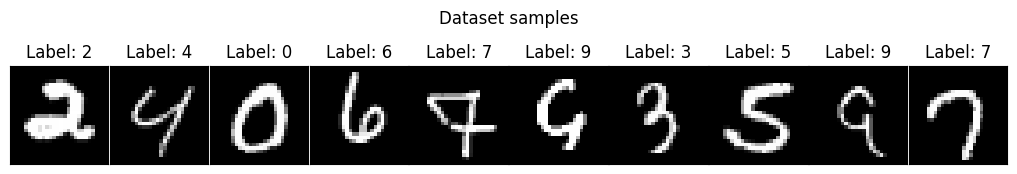

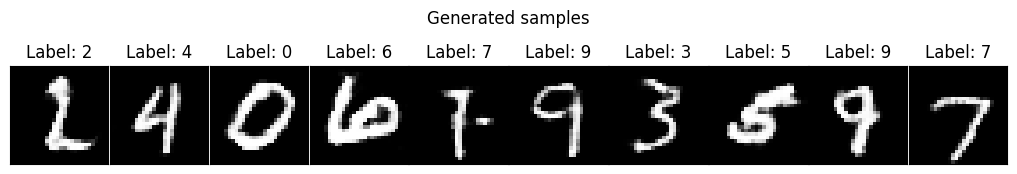

Epoch: 9, G loss: 1.0203248260443463, D loss: 1.2002008405512075


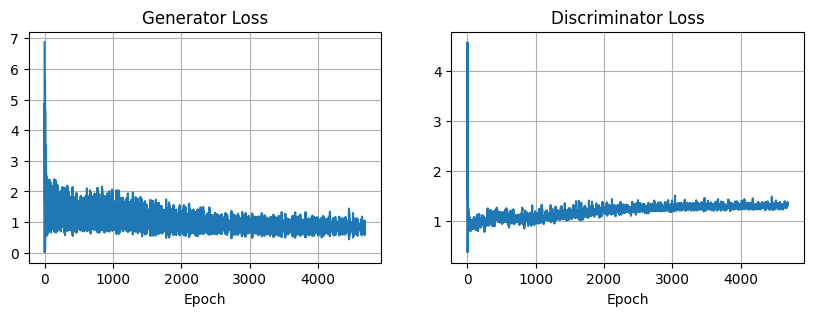

100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


In [87]:
train_losses = train_ns(
    train_mnist_loader,
    G_NS,
    D_NS,
    G_NS_optim,
    D_NS_optim,
    discriminator_steps=DISC_STEPS,
    n_epochs=N_EPOCHS,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=VIS_STEPS,
)

## 4. GAN with class-conditional generator and unconditional discriminator (3 points)

For this task, you need to:  
1. Implement the architecture for an **unconditional discriminator** (1 point);  
2. Implement the **training steps and algorithm** (2 points). 

In [126]:
class ConvDiscriminator(nn.Module):
    def __init__(
        self,
    ) -> None:
        super().__init__()
        self.n_channels = 64


        self.net = nn.Sequential(
            nn.Conv2d(1, self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_channels, 2 * self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2 * self.n_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2 * self.n_channels, 4 * self.n_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(4 * self.n_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.linear = nn.Linear(4 * self.n_channels * 4 * 4, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = self.net(x)
        x = x.view(batch_size, -1)
        logits = self.linear(x)
        return logits

In [127]:
def ns_gen_step_uncond(
    X: torch.Tensor, G: nn.Module, D: nn.Module, G_optim: torch.optim.Optimizer, num_classes: int
) -> torch.Tensor:
    # YOUR CODE HERE
    # G.train()
    # D.eval()
    batch_size = X.size(0)
    labels = torch.randint(num_classes, size=(batch_size, ))
    X_gen = G.sample(batch_size, labels)
    scores_gen = D(X_gen)
    loss = F.softplus(-scores_gen).mean()
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()


def ns_discr_step_uncond(
    X: torch.Tensor,
    G: nn.Module,
    D: nn.Module,
    D_optim: torch.optim.Optimizer,
    r1_regularizer: float = 1.0,
) -> torch.Tensor:
    # G.eval()
    # D.train()
    D_optim.zero_grad()
    batch_size = X.size(0)
    labels = torch.randint(10, size=(batch_size, ))
    with torch.no_grad():
        X_gen = G.sample(batch_size, labels)
    X.requires_grad_()
    scores_gen = D(X_gen)
    scores_real = D(X)
    loss_gen = F.softplus(scores_gen).mean()
    loss_real = F.softplus(-scores_real).mean()
    scores_real.sum().backward(retain_graph=True, create_graph=True)
    gradients = X.grad # the same shape as X
    grad_penalty = (
        gradients.view(gradients.size(0), -1).norm(2, dim=1) ** 2
    ).mean()
    D_optim.zero_grad()
    loss = loss_gen + loss_real + r1_regularizer * grad_penalty

    loss.backward()
    D_optim.step()
    gradients.detach_() # to avoid memory leak!
    return loss.item()

In [128]:
def train_ns_uncond(
    train_loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    G_optim: torch.optim.Optimizer,
    D_optim: torch.optim.Optimizer,
    discriminator_steps: int,
    n_epochs: int,
    r1_regularizer: float = 1.0,
    visualize_steps: int = 10,
) -> None:
    disc_losses = []
    gen_losses = []
    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for X, labels in train_loader:
            X = X.to(DEVICE)
            labels = labels.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = ns_discr_step_uncond(X, G, D, D_optim, r1_regularizer)
            disc_losses.append(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = ns_gen_step_uncond(X, G, D, G_optim, 10)
                gen_losses.append(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            with torch.no_grad():
                clear_output()
                plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")
                X_gen = G.sample(10, labels[:10])
                plot_images(X_gen.detach().cpu(), labels[:10].cpu(), "Generated samples")

                print(f"Epoch: {epoch_i}, G loss: {np.mean(gen_losses)}, D loss: {np.mean(disc_losses)}")
                plot_losses(gen_losses, disc_losses)

In [136]:
BATCH_SIZE = 128
DISC_STEPS = 1
LR = 2e-4
R1_REGULARIZER = 0.5
N_EPOCHS = 10
VIS_STEPS = 1

In [137]:
train_mnist_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
G_UNCOND = ConditionalConvGenerator(num_classes=10).to(DEVICE)
D_UNCOND = ConvDiscriminator().to(DEVICE)
G_UNCOND_optim = torch.optim.RMSprop(G_UNCOND.parameters(), lr=LR)
D_UNCOND_optim = torch.optim.RMSprop(D_UNCOND.parameters(), lr=LR)

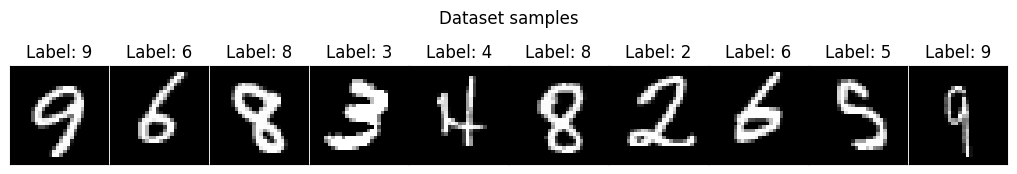

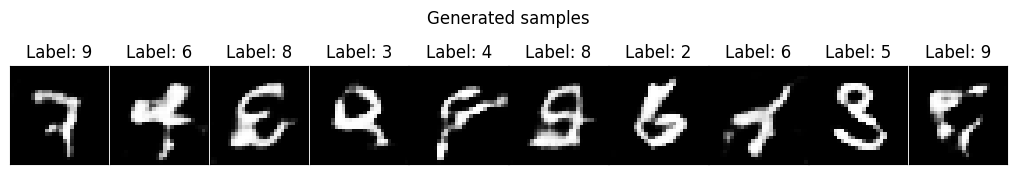

Epoch: 9, G loss: 1.2779583837654291, D loss: 1.0507198373646116


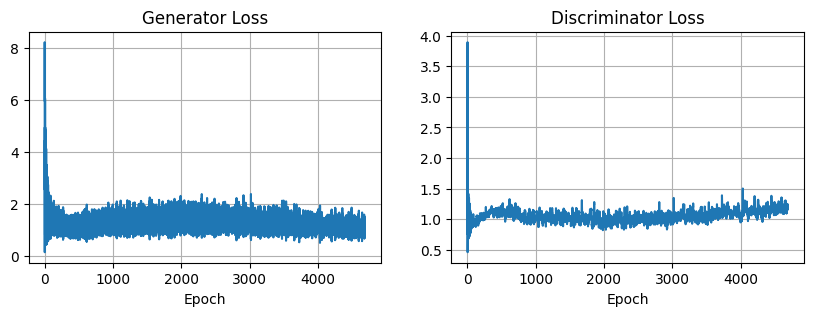

100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


In [138]:
train_losses = train_ns_uncond(
    train_mnist_loader,
    G_UNCOND,
    D_UNCOND,
    G_UNCOND_optim,
    D_UNCOND_optim,
    discriminator_steps=DISC_STEPS,
    n_epochs=N_EPOCHS,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=VIS_STEPS,
)

## 5. Evaluation of Model Results (6 points)  
In this task, you need to evaluate the performance of each trained model **on the MNIST test subset**.  

### 5.1 Qualitative Evaluation (1 point)  

Visualize **class-conditional generation** from models with a **conditional discriminator**, specifying the class label, trained using:  
- **Vanilla GAN loss** 
- **NS-GAN loss (with $R_1$ regularization)** 
- **Class-conditional generation** from model with an **unconditional discriminator**

In [139]:

pix_range = (-1., 1.)
_m, _std = pix_range[0]/float(pix_range[0] - pix_range[1]), 1./float(pix_range[1] - pix_range[0])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([_m],[_std]) 
])

test_dataset = MNIST(
    root='./',      # where to store/download the data
    train=False,         # use the training split
    download=False,      # download if not already there
    transform=transform # apply the transforms
)


In [140]:
dataloader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False
)

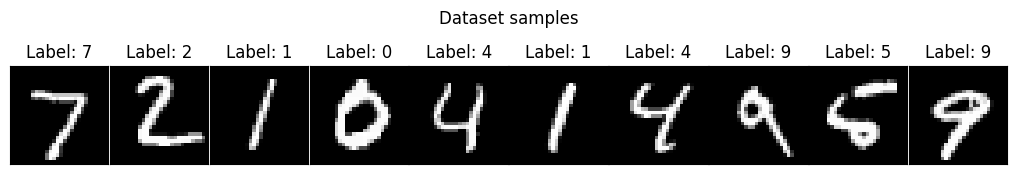

In [141]:
X, labels = next(iter(dataloader))
plot_images(X[:10].cpu(), labels[:10].cpu(), "Dataset samples")

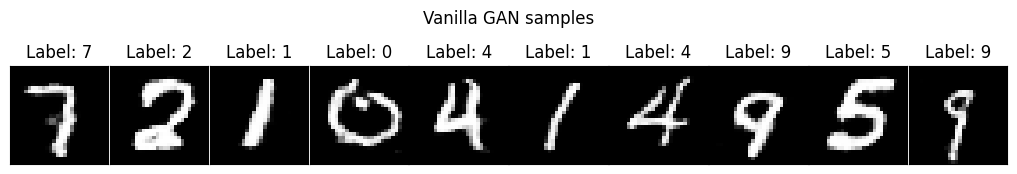

In [142]:
X_gen_cond = G_cond.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_cond.detach().cpu(), labels[:10].cpu(), "Vanilla GAN samples")

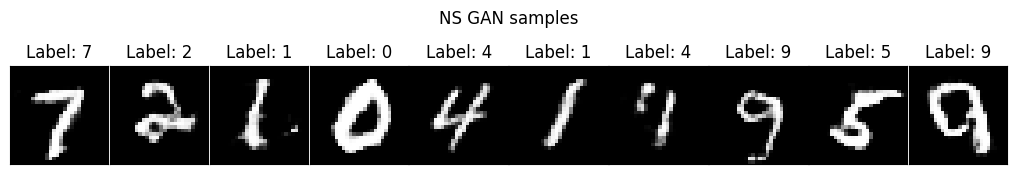

In [143]:
X_gen_ns = G_NS.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_ns.detach().cpu(), labels[:10].cpu(), "NS GAN samples")

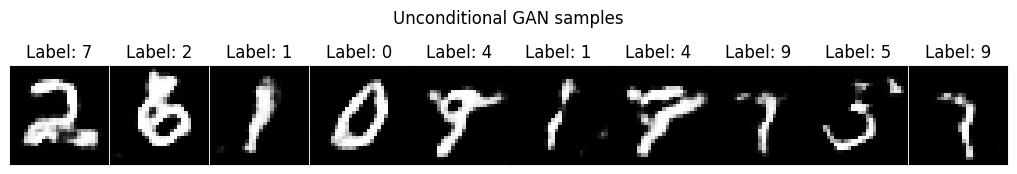

In [144]:
X_gen_uncond = G_UNCOND.sample(10, labels[:10].to(DEVICE))
plot_images(X_gen_uncond.detach().cpu(), labels[:10].cpu(), "Unconditional GAN samples")

### 5.2 Quantitative Evaluation (FID) (3 points) 

You should:
- Compute the **Frechet Inception Distance (FID)** for all trained models:  
    - Conditional discriminator (Vanilla GAN loss)  
    - Conditional discriminator (NS-GAN loss)  
    - Unconditional discriminator
- Compare FID scores across models to assess which architecture and loss function yield the most realistic generations.

Compute FID metrics for `MNIST` images with `torchmetrics` by following these steps:

1. **Preprocess images:** Resize to 299×299 and convert from grayscale to RGB by stacking 3 times color channels.
2. **Implement FID calculation** using the prepared images

In [145]:
def preprocess_for_fid(images: torch.Tensor, device: torch.device = DEVICE) -> torch.Tensor:
    """
    Preprocess grayscale [B, 1, H, W] images normalized to [-1, 1] for FID:
        1. Scale from [-1, 1] to [0, 1]
        2. Convert to RGB by repeating channels
        3. Resize to (299, 299)
        4. Convert to uint8 in [0, 255]

    Returns:
        torch.Tensor: Preprocessed images [B, 3, 299, 299] in uint8 format
    """
    if images.dim() == 3:
        images = images.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]

    images = ((images + 1.0) / 2.0).clamp(0.0, 1.0)

    # Batch operations for efficiency
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)   # [B, 1, 299, 299]
    images = images.repeat(1, 3, 1, 1) # YOUR CODE HERE  # [B, 3, 299, 299] (grayscale->RGB)

    # Convert to uint8 and ensure proper range
    images = (images * 255.0).clamp(0, 255).to(torch.uint8) # YOUR CODE HERE

    return images.to(device)

In [146]:
@torch.no_grad()
def compute_fid(
    generator: ConditionalConvGenerator,
    loader: DataLoader,
    num_features: int = 2048,
    device: torch.device = DEVICE,
) -> dict[str, float]:
    """Compute Fréchet Inception Distance (FID) between real and generated samples."""
    fid = FrechetInceptionDistance(feature=num_features).to(device).eval()

    for real_imgs, labels in loader:
        batch_size = real_imgs.size(0)

        real_imgs = preprocess_for_fid(real_imgs.to(device), device)
        labels = labels.to(device)

        fake_imgs = generator.sample(batch_size, labels)
        fake_imgs = preprocess_for_fid(fake_imgs, device)

        fid.update(real_imgs, real=True)
        fid.update(fake_imgs, real=False)

    output = fid.compute().detach().item()

    fid.reset()

    return output

In [147]:
fid_cond = compute_fid(G_cond, dataloader)
fid_cond

16.60652732849121

In [148]:
fid_NS = compute_fid(G_NS, dataloader)
fid_NS

17.077234268188477

In [149]:
fid_UNCOND = compute_fid(G_UNCOND, dataloader)
fid_UNCOND

44.197731018066406

### 5.3 Summary & Conclusions (2 points)
- Do the results differ between **Vanilla GAN loss** and **NS-GAN ($R_1$) loss**?  
- Do the results differ when using a **class-conditional discriminator** vs. an **unconditional discriminator**?  
- Based on both **visual inspection** and **FID scores**, justify which approach performs best.  

**Reporting**: Include FID values in a table for clear comparison. 
Example:  

| Model Type               | Loss Function       | FID Score ($\downarrow$ better) |  
|--------------------------|---------------------|----------------------|  
| Conditional Discriminator | Vanilla GAN         | 7.2                 |  
| Conditional Discriminator | NS-GAN ($R_1$)         | 8.2                 |  
| Unconditional Discriminator | NS-GAN ($R_1$)      | 10.9                |  

**Observations:** YOU OBSERVATIONS HERE.